# Train Models using Feast historical data

* Collect historical features from Feast
* Rebuild the MNIST dataset from the features
* Train different models using the dataset
* Register models using Model Registry

In [1]:
!pip uninstall -r requirements.txt --yes
# !pip install feast==0.36.0
# !pip install typing_extensions

Found existing installation: feast 0.36.0
Uninstalling feast-0.36.0:
  Successfully uninstalled feast-0.36.0
Found existing installation: psycopg2 2.9.9
Uninstalling psycopg2-2.9.9:
  Successfully uninstalled psycopg2-2.9.9
Found existing installation: onnxruntime 1.17.1
Uninstalling onnxruntime-1.17.1:
  Successfully uninstalled onnxruntime-1.17.1


In [3]:
!pip install --upgrade pip
!cat requirements.txt
!pip install -q -r requirements.txt

feast==0.36.0
psycopg2>=2.9
onnxruntime


## Collect historical data

**Note**: update this value to match the actual data

In [10]:
from datetime import datetime, timedelta
ts = datetime(2024, 4, 1, 12, 30, 0)

In [11]:
%env REPO_PATH=mnist_demo/feature_repo/

env: REPO_PATH=mnist_demo/feature_repo/


In [12]:
from feast import FeatureStore
import pandas as pd
import os

print(f'Testing for {ts}')
entity_df = pd.DataFrame.from_dict(
    {
        "image_id": list(range(1, 70001)),
        "event_timestamp": [ts] * 70000,
    }
)

store = FeatureStore(repo_path=os.environ['REPO_PATH'])    
features = [f"mnist:feature_{i+1}" for i in range(28)]
features.append("mnist:number")
historical_df = store.get_historical_features(
    entity_df=entity_df,
    features=features,
).to_df()

Testing for 2024-04-01 12:30:00


In [13]:
len(historical_df)

70000

In [14]:
historical_df.head()

,image_id,event_timestamp,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,number
0,11,2024-04-01 12:30:00,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.403...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.07450980392156863,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.6431372549019608,0....","(0.0,0.0,0.0,0.0,0.0,0.0,0.2235294117647059,0....","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.549019607843137...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02745098039...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",3
1,16,2024-04-01 12:30:00,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1568627...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6470588...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16862745098...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.53725490196...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26274509803...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",7
2,34,2024-04-01 12:30:00,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0117647...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1960784...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15686274509...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058823529411764...","(0.0,0.0,0.0,0.0,0.0,0.0,0.11764705882352941,0...","(0.0,0.0,0.0,0.0,0.0,0.01568627450980392,0.627...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",9
3,37,2024-04-01 12:30:00,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",...,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1019607...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...",6
4,39,2024-04-01 12:30:00,"(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...","(0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [15]:
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 31 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   image_id         70000 non-null  int64         
 1   event_timestamp  70000 non-null  datetime64[ns]
 2   feature_1        70000 non-null  object        
 3   feature_2        70000 non-null  object        
 4   feature_3        70000 non-null  object        
 5   feature_4        70000 non-null  object        
 6   feature_5        70000 non-null  object        
 7   feature_6        70000 non-null  object        
 8   feature_7        70000 non-null  object        
 9   feature_8        70000 non-null  object        
 10  feature_9        70000 non-null  object        
 11  feature_10       70000 non-null  object        
 12  feature_11       70000 non-null  object        
 13  feature_12       70000 non-null  object        
 14  feature_13       70000 non-null  objec

## Prepara dataset

Remove rows with null features

In [16]:
for id in range(28):
    historical_df.dropna(subset=[f'feature_{id+1}'], inplace=True)

In [17]:
len(historical_df)

70000

In [18]:
# import base64

# # String to encode
# original_string = ','.join([historical_df[f'feature_{id+1}'].iloc[0] for id in range(28)])

# # Encode the string to Base64
# encoded_string = base64.b64encode(original_string.encode()).decode()

# print(original_string)
# print(len(original_string))
# print(encoded_string)
# print(len(encoded_string))

Rebuild the MNIST dataset.

Goal is to recreate the `numpy` arrays that can feed the trained models.

In [19]:
images = []

Load features and revert column to rows.

**Note**: `feature_N` columns contain string representation of `list<float>`, so they must be reverted to the original data types.

The execution of these commands can take some minutes.

In [20]:
import numpy as np
import ast

for index in range(len(historical_df)):
    image_id = historical_df['image_id'].iloc[index]
    # print(f'Rebuild {image_id} at index {index}')
    image = [list(map(float, ast.literal_eval(
        historical_df[f'feature_{id+1}'].iloc[index]))) for id in range(28)]
    images.append(image)

Extract the prediction column `number`

In [22]:
numbers = []
for index in range(len(historical_df)):
    numbers.append(int(historical_df['number'].iloc[index]))
print(len(numbers))

70000


Assign a fixed percentage of 20% to testing purposes

In [23]:
split = int(len(images) * 0.8)
train_images = images[:split]
test_images = images[split:]
train_numbers = numbers[:split]
test_numbers = numbers[split:]

X_train = np.array(train_images)
y_train = np.array(train_numbers)
X_test = np.array(test_images)
y_test = np.array(test_numbers)

In [24]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (56000, 28, 28)
y_train: (56000,)
X_test: (14000, 28, 28)
y_test: (14000,)


Plot some data samples to validate the transformation

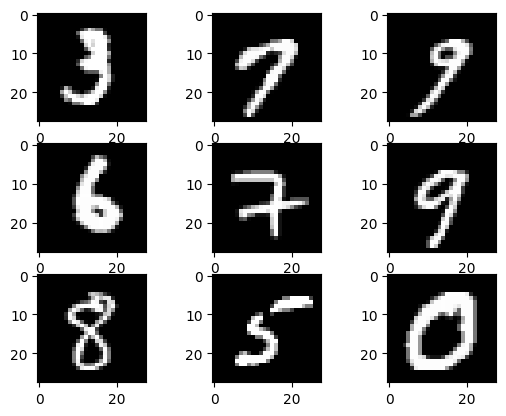

In [25]:
from matplotlib import pyplot
for i in range(9):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

## Train simple neural network

Let's train a simple neural network.

In [26]:
model_name = 'simpleNN'

In [27]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten

model = Sequential()

model.add(Flatten(input_shape=(28,28)))
model.add(Dense(128,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(10,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.summary()

2024-04-11 10:03:32.712638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 10:03:33.449308: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 104938 (409.91 KB)
Trainable params: 104938 (409.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
history = model.fit(X_train,y_train,epochs=10,validation_split=0.2)

Epoch 1/10


2024-04-11 10:03:36.818445: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 140492800 exceeds 10% of free system memory.


1383/1400 [============================>.] - ETA: 0s - loss: 0.2979 - accuracy: 0.9131

2024-04-11 10:03:40.657667: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35123200 exceeds 10% of free system memory.


1400/1400 [==============================] - 4s 3ms/step - loss: 0.2961 - accuracy: 0.9137 - val_loss: 0.1566 - val_accuracy: 0.9533
Epoch 2/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.1232 - accuracy: 0.9628 - val_loss: 0.1201 - val_accuracy: 0.9638
Epoch 3/10
1400/1400 [==============================] - 4s 3ms/step - loss: 0.0839 - accuracy: 0.9741 - val_loss: 0.1072 - val_accuracy: 0.9678
Epoch 4/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0599 - accuracy: 0.9814 - val_loss: 0.1052 - val_accuracy: 0.9687
Epoch 5/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0469 - accuracy: 0.9850 - val_loss: 0.0963 - val_accuracy: 0.9716
Epoch 6/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0357 - accuracy: 0.9878 - val_loss: 0.1044 - val_accuracy: 0.9716
Epoch 7/10
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0284 - accuracy: 0.9914 - val_loss: 0.0922 - val_accuracy: 0.9749
Epo

Evaluate model accuracy using test data

In [31]:
from sklearn.metrics import accuracy_score
from IPython.display import Markdown as md

def evaluateModelAccuracy(model, model_name):
    y_prob = model.predict(X_test)
    y_pred = y_prob.argmax(axis=1)
    accuracy = accuracy_score(y_test,y_pred)
    print(f'Prediction accuracy for model `{model_name}` is: {round(accuracy * 100, 2)}%
    ''')


In [32]:
evaluateModelAccuracy(model, model_name)

139/438 [========>.....................] - ETA: 0s

2024-04-11 10:05:06.919024: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 43904000 exceeds 10% of free system memory.


438/438 [==============================] - 0s 1ms/step

    **Prediction accuracy for model `simpleNN` is**: 97.41%
    


### Evaluate the trained model

In [ ]:
import matplotlib.pyplot as plt

def evaluateModelForSample(model, sample_id):
    plt.imshow(X_test[sample_id], cmap="Greys")
    plt.title(f'X_test[{sample_id}]:')
    plt.show()
    prediction = model.predict(X_test[sample_id].reshape(1,28,28)).argmax(axis=1)[0]
    print(f'prediction for sample {sample_id} is: ', prediction)
    print(f'**Note**: the calculated prediction {prediction} must match the number plotted above. If not, the test failed')
    

In [ ]:
evaluateModelForSample(model, 1)

### Save the model as ONNX file

In [ ]:
import tensorflow as tf
import onnx
import onnxruntime as ort
import tf2onnx

def saveModel(model, model_name):
    input_signature = [tf.TensorSpec([1, 28, 28], tf.double, name='x')]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=12)
    file_name = f"{model_name}.onnx"
    onnx.save(onnx_model, file_name)
    print(f"Saved as {file_name}")
    return file_name

In [ ]:
file_name = saveModel(model, model_name)

### Test the saved model

In [ ]:
N = 19
plt.imshow(X_test[N], cmap="Greys")
plt.title(f'X_test[{N}]:')
plt.show()

In [ ]:
model_onnx = onnx.load(file_name)
output = [node.name for node in model_onnx.graph.output]
print(output)

sess = ort.InferenceSession(file_name)
results_ort = sess.run([output[0]], {'x': X_test[N].reshape(1,28,28)})
prediction = results_ort[0].argmax(axis=1)[0]
print('prediction: ', prediction)

**Note**: the calculated prediction must match the number plotted above. If not, the test failed

### Register the model

In [ ]:
os.environ['accesskey'] = 'boIJgrAVBuIcmkNh1Dv6'
os.environ['secretkey'] = 'yGGRnBVRHTWN1un8il2dZjq3JhaTe0kmzmOZjRZT'
# 'http://minio-service.kubeflow.svc.cluster.local:9000'
s3url = 'https://play.min.io:9000'
bucket_name = 'feast'

In [ ]:
import boto3

def registerTrainedModel(model, model_name, file_name):
    registeredmodel_name = "mnist"
    version_name = "v."+model_name+"."+datetime.now().strftime("%Y%m%d%H%M%S")
    print(f"Will be using: {registeredmodel_name}:{version_name} in the remainder of this task")

    # Updated config for https://play.min.io:9443/
    s3 = boto3.resource(
        service_name='s3',
        # region_name='default',
        aws_access_key_id=os.environ['accesskey'],
        aws_secret_access_key=os.environ['secretkey'],
        # use_ssl=False,
        endpoint_url=s3url,
        # config=boto3.session.Config(signature_version='s3v4'),
        verify=False
    )

    odh_secret_name = f'aws-connection-{bucket_name}'
    in_bucket_path = version_name
    in_bucket_target = f'{in_bucket_path}/{file_name}'
    full_bucket_target = f's3://{bucket_name}/{in_bucket_target}'

    my_bucket = s3.Bucket(bucket_name)
    my_bucket.upload_file(file_name, in_bucket_target)

    print(f"Objects in the {bucket_name} bucket:")
    for obj in my_bucket.objects.filter():
        print(obj.key)

In [ ]:
registerTrainedModel(model, model_name, file_name)

## Train a convoluted neural network

Let's train a an alternative, a convoluted neural network:

In [ ]:
model_name = 'convolutedNN'

In [ ]:
model = Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(X_train,y_train,epochs=3)

In [ ]:
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=1)
accuracy = accuracy_score(y_test,y_pred)
md(f'''
**Prediction accuracy for model `{model_name}` is**: {round(accuracy * 100, 2)}%
''')


### Evaluate the trained model

In [ ]:
evaluateModelForSample(model, 19)

### Save the model as ONNX file

In [ ]:
input_signature = [tf.TensorSpec([1, 28, 28], tf.double, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=12)
onnx.save(onnx_model, "model2.onnx")

In [ ]:
file_name = saveModel(model, model_name)